In [1]:
from collections import Counter
from pprint import pprint
from pathlib import Path
import pandas as pd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx
from community import community_louvain
from helper import Preprocess
from sklearn.neighbors import NearestNeighbors
import numpy as np
from numpy import linalg as LA

from sklearn.manifold import TSNE

In [2]:
FILE_NAME = 'rename_64_64_relu_softmax_25_10_adjacentTF_1e-4'
DATA_DIR = Path("../../data/")

we first explore the original graph (before embedding)

In [3]:
data_processor = Preprocess()
df = data_processor.raw2train(DATA_DIR)

G_original = nx.from_pandas_edgelist(df[['source', 'target', 'weight']], 'source', 'target', edge_attr='weight', create_using=nx.Graph)
print(nx.info(G_original))

Raw data:
Shape of GM12878: (506074, 5)
Shape of K562: (954968, 5)
Shape of PPI: (21038, 3)
-----------------------------------------
After processing:
Number of GM12878 edges: 354514
Number of K562 edges: 390088
Number of PPI edges (Undirectional): 21038
--------
Number of TFs: 69
-----------------------------------------
Name: 
Type: Graph
Number of nodes: 18573
Number of edges: 761241
Average degree:  81.9729


We first map the vectors in embedded space to a graph using KNN algorithm

In [ ]:
emb_df = pd.read_csv(f'./emb/{FILE_NAME}.csv', index_col=0)
emb_df = emb_df.drop(['type'], axis='columns')

# map node index to node name
idx = emb_df.index
idx2name = dict()
for i, name in enumerate(idx):
    idx2name[i] = name
emb = emb_df.to_numpy()

# use KNN to find nearest neighbors of every node
print('Running KNN...')
nbrs = NearestNeighbors(n_neighbors=50, algorithm='ball_tree').fit(emb)
distance, indices = nbrs.kneighbors(emb)
print('KNN completed!')

# create edgelist
edgelist = []
print('Creating edgelist...')
for i, name in enumerate(idx):
    for j in range(len(indices[i])):
        temp = []
        if j != 0:
            temp.append(name)
            temp.append(idx2name[indices[i][j]])
            temp.append(distance[i][j])
            edgelist.append(temp)

edgelist_df = pd.DataFrame(edgelist)
edgelist_df.columns = ['source', 'target', 'distance']
# edgelist_df['weight'] = edgelist_df['distance'].map(lambda x: 1-x)
edgelist_df.shape

edgelist_df.head()

In [6]:
# G = nx.from_pandas_edgelist(edgelist_df[['source', 'target', 'weight']], 'source', 'target', edge_attr='weight', create_using=nx.Graph)
G = nx.from_pandas_edgelist(edgelist_df[['source', 'target']], 'source', 'target', create_using=nx.Graph)

print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 18573
Number of edges: 636876
Average degree:  68.5808


In [7]:
# Run Louvein algorithm for clustering
partition = community_louvain.best_partition(G, resolution=0.8, random_state=0)
max(set(partition.values()))

19

Now we have a clustered network based on the embedding of each node, we create a new column to record class of each node.

In [8]:
emb_df['class'] = emb_df.index.map(lambda x: partition[x])
cluster_df = emb_df[['class']].copy(deep=True)
cluster_df.groupby(['class'])
def is_tf(name):
    if name[-3:] == '_gm':
        return 2
    elif name[-2:] == '_k':
        return 1
    else:
        return 0
cluster_df['is_tf'] = cluster_df.index.map(lambda name: is_tf(name))

gm_cluster_df = cluster_df[cluster_df['is_tf'] == 2]
k_cluster_df = cluster_df[cluster_df['is_tf'] == 1]
gene_cluster_df = cluster_df[cluster_df['is_tf'] == 0]

print('Cluster of K: ', Counter(k_cluster_df['class']))
print('Cluster of GM: ', Counter(gm_cluster_df['class']))
print('Cluster of normal gene: ', Counter(gene_cluster_df['class']))

Cluster of K:  Counter({15: 69})
Cluster of GM:  Counter({15: 69})
Cluster of normal gene:  Counter({3: 1908, 5: 1807, 9: 1683, 7: 1532, 14: 1321, 11: 1269, 2: 1234, 8: 1170, 16: 1075, 1: 1023, 6: 841, 0: 832, 13: 652, 4: 554, 17: 424, 12: 347, 18: 327, 10: 322, 19: 91, 15: 23})


In [9]:
mean_clusters = emb_df.groupby('class').mean()

all_embeddings = emb_df.drop(['class'], axis=1).append(mean_clusters)

print('Running TSNE...')
trans = TSNE(n_components=2, random_state=0)
emb_transformed = pd.DataFrame(trans.fit_transform(all_embeddings), index=all_embeddings.index)

print('Mapping names to classes...')
def name2class(name):
    if type(name) == int:
        return 10
    else:
        if name[-2:] == '_k':
            return 1
        elif name[-3:] == '_gm':
            return 2
        else:
            return 0
emb_transformed['type'] = emb_transformed.index.map(name2class)
emb_transformed



Running TSNE...
Mapping names to classes...


0          1  type
MCHR1    2.425944  19.757919     0
PSMD9   14.737146  58.857929     0
CRIP1   53.021172 -19.065672     0
GIMAP4  19.284235 -57.361893     0
GATM   -36.581116   8.075550     0
...           ...        ...   ...
15     -51.401020 -69.409798    10
16     -10.002665 -71.029633    10
17      72.225006  30.865810    10
18      71.761589  12.622641    10
19      77.975899 -11.587328    10

[18593 rows x 3 columns]

In [10]:
Path(f"./result/{FILE_NAME}").mkdir(parents=True, exist_ok=True)

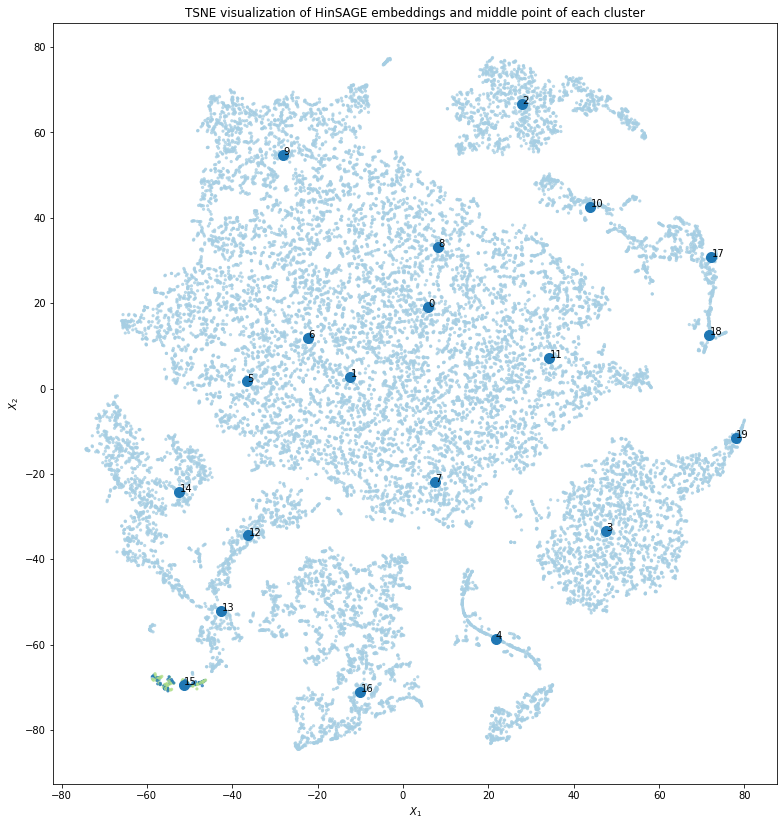

In [11]:
alpha = 0.7

fig, ax = plt.subplots(figsize=(14, 14))
ax.scatter(
    emb_transformed[0],
    emb_transformed[1],
    c=emb_transformed["type"],
    cmap="Paired",
    alpha=alpha,
    s=5
)
ax.scatter(
    emb_transformed[emb_transformed['type'] == 10][0],
    emb_transformed[emb_transformed['type'] == 10][1],
    s=100
)

# Annotate ID of each cluster
n_clusters = max(set(partition.values())) + 1
for i in range(n_clusters):
    ax.annotate(str(i), (emb_transformed[emb_transformed['type'] == 10].loc[i][0]+.05, emb_transformed[emb_transformed['type'] == 10].loc[i][1]+.05))
# for i, txt in enumerate(nodes):
#     if txt in target_txts or False:
#         ax.annotate(txt, (emb_transformed.iloc[i][0]+.05, emb_transformed.iloc[i][1]+.05))


ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
plt.title(f"TSNE visualization of HinSAGE embeddings and middle point of each cluster")

plt.savefig(f'./result/{FILE_NAME}/cluster.png', dpi=150)
plt.show()

We could also color the graph by the class of each node

Running TSNE...


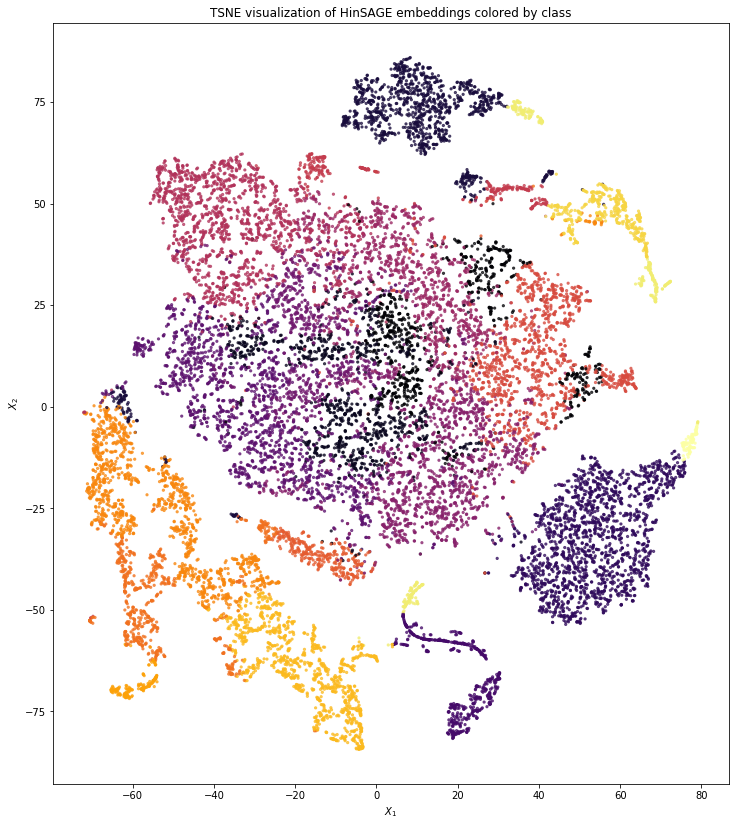

In [12]:
_idx = list(emb_df.columns)[:-1]

print('Running TSNE...')
trans = TSNE(n_components=2, random_state=0)
emb_transformed = pd.DataFrame(trans.fit_transform(emb_df[_idx]), index=emb_df.index)
emb_transformed['class'] = emb_df['class']

fig, ax = plt.subplots(figsize=(14, 14))
ax.scatter(
    emb_transformed[0],
    emb_transformed[1],
    c=emb_transformed["class"],
    cmap="inferno",
    alpha=alpha,
    s=5
)

ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
plt.title(f"TSNE visualization of HinSAGE embeddings colored by class")

plt.savefig(f'./result/{FILE_NAME}/individual_cluster.png', dpi=150)
plt.show()

We could calculate the distance between clusters, the distance is defined as how many hops are needed from one node to another

In [12]:
gms = list(gm_cluster_df.index)
ks = list(k_cluster_df.index)
genes = list(gene_cluster_df.index)

print(len(genes))
cluster_df

18435


class  is_tf
MCHR1         0      0
PSMD9         2      0
CRIP1         3      0
GIMAP4        4      0
GATM          5      0
...         ...    ...
ERCC5        13      0
MARVELD1      8      0
YTHDC2        2      0
SRC          16      0
C1GALT1       5      0

[18573 rows x 2 columns]

In [13]:
shortest_paths = {}
tfs = gms + ks

shortest_paths_df = pd.DataFrame(index=genes, columns=tfs, dtype=np.int16)

for tf in tfs:
    shortest_paths[tf] = nx.shortest_path_length(G_original, source=tf)


In [14]:
shortest_paths_df = pd.DataFrame(shortest_paths)
shortest_paths_df = shortest_paths_df[~shortest_paths_df.index.isin(tfs)]
shortest_paths_df.sort_index(inplace=True)

shortest_paths_cluster = cluster_df[cluster_df.index.isin(shortest_paths_df.index)].sort_index()
# shortest_paths_cluster
shortest_paths_df['cluster'] = shortest_paths_cluster['class']

# Mode
# cluster_rank = shortest_paths_df.set_index('cluster').stack().groupby(level='cluster').agg(lambda x:x.value_counts().index[0]).to_frame().sort_values([0])

# Mean
cluster_rank = shortest_paths_df.set_index('cluster').stack().groupby(level='cluster').mean().to_frame().sort_values([0])

cluster_rank.to_csv(f'./result/{FILE_NAME}/cluster_rank.csv', index=True, header=True)
cluster_rank

0
cluster          
3        1.728971
2        1.762461
12       1.774527
14       1.793536
17       1.825694
16       1.887873
13       1.970283
19       2.056617
15       2.094833
18       2.125183
4        2.239523
1        2.246221
6        2.331455
7        2.334989
5        2.445835
8        2.509990
11       2.561569
10       2.661108
0        2.729698
9        2.808748

In [15]:
cluster0 = shortest_paths_df[shortest_paths_df['cluster'] == 0]
maxi_hop = max(shortest_paths_df[list(shortest_paths_df.columns)[:-1]].max())

hop_count_df = pd.DataFrame(data=0, index=['cluster_' + str(i) for i in range(n_clusters)], columns=[i for i in range(maxi_hop+1)])

for i in range(n_clusters):
    _cluster = shortest_paths_df[shortest_paths_df['cluster'] == i].drop(['cluster'], axis=1)
    vals = _cluster.stack().value_counts()
    vals_idx = vals.index.to_list()
    vals_count = vals.to_list()
    counts = dict(zip(vals_idx, vals_count))

    incr = [0] * (maxi_hop + 1)
    # print(counts)
    for key in counts.keys():
        incr[key] += counts[key]
    hop_count_df.loc['cluster_'+str(i)] += incr
    
hop_count_df

0       1      2       3     4   5
cluster_0   0   15216    620   98963    17   0
cluster_1   0   51344   3726   86104     0   0
cluster_2   0   74485  61773   34034     0   0
cluster_3   0  122346  89975   50983     0   0
cluster_4   0     641  57029   18611   171   0
cluster_5   0   66446   5299  177620     1   0
cluster_6   0   37408   2774   75876     0   0
cluster_7   0   68251   4096  139065     4   0
cluster_8   0   38423   2272  120764     1   0
cluster_9   0   21806    807  209641     0   0
cluster_10  0    5839   4058   33959   483  97
cluster_11  0   37105   2577  135435     2   3
cluster_12  0   22688  13307   11891     0   0
cluster_13  0   31690  30399   24551  2198  34
cluster_14  0   74187  71588   36497    26   0
cluster_15  0     806   1332     965    71   0
cluster_16  0   42655  80915   23539  1241   0
cluster_17  0   21617  25537   11298    60   0
cluster_18  0    5059  29402   10622    43   0
cluster_19  0    2191   7465    2902     0   0

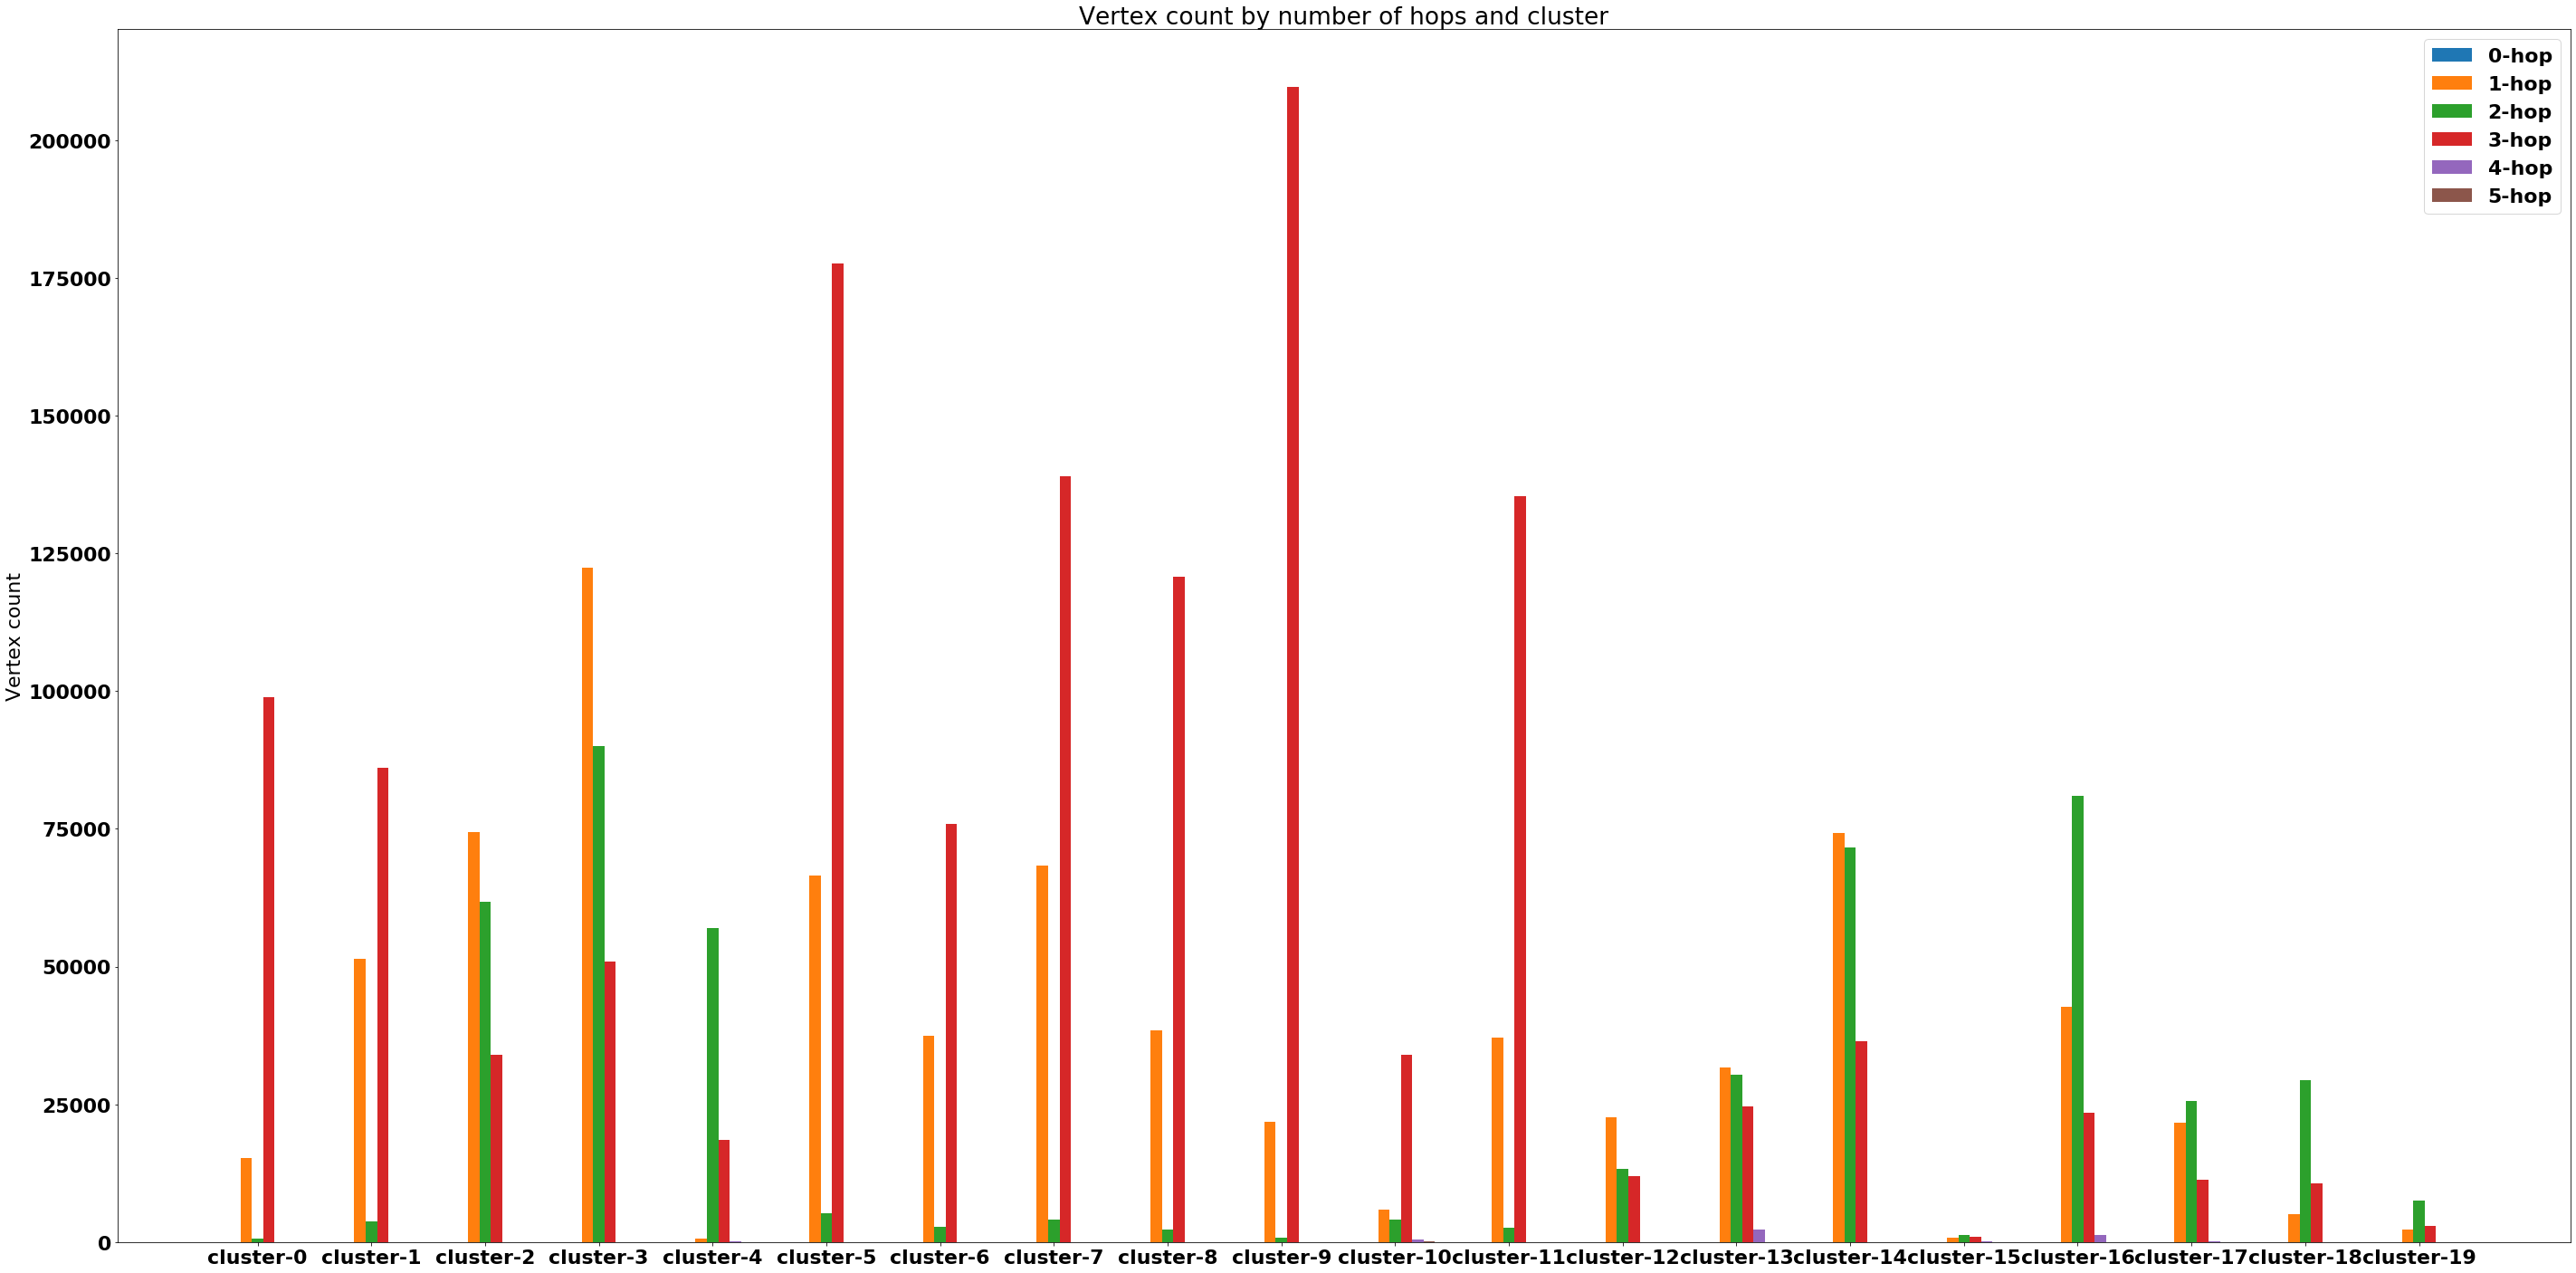

In [16]:
import matplotlib
font = {'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

data_to_plot = []
for i in range(maxi_hop+1):
    data_to_plot.append(hop_count_df[i].to_numpy())

# display(data_to_plot)
labels = ['cluster-' + str(i) for i in range(n_clusters)]
x = np.arange(len(labels))  # the label locations
width = 0.1  # the width of the bars

fig, ax = plt.subplots()
fig.set_figheight(20)
fig.set_figwidth(40)


rects = []
tags = [str(i) + '-hop' for i in range(maxi_hop+1)]
for i in range(maxi_hop+1):
    rects.append(ax.bar(x+i*width - maxi_hop//2 * width, data_to_plot[i].tolist(), width, label=tags[i]))

ax.set_ylabel('Vertex count')
ax.set_title('Vertex count by number of hops and cluster')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# for rect in rects:
#     autolabel(rect)

# autolabel(rects1)
# autolabel(rects2)


fig.tight_layout()
plt.savefig(f'./result/{FILE_NAME}/barplot.png', dpi=150)
plt.show()